# Event handling in ProbNum


## Quickstart

In [1]:
from probnum import diffeq, randvars, statespace, randprocs, problems

from probnum.problems.zoo import diffeq as diffeq_zoo

import matplotlib.pyplot as plt
import numpy as np

In [2]:
ivp = diffeq_zoo.lotkavolterra(tmax=15)

In [3]:

sol = diffeq.probsolve_ivp(ivp.f, ivp.t0, ivp.tmax, ivp.y0, atol=1e-1, rtol=1e-1, time_stamps=np.linspace(9., 10., 100))

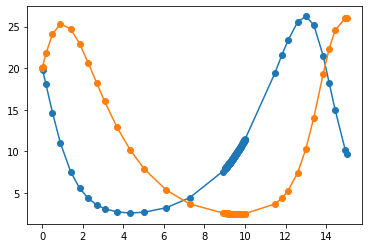

In [4]:
plt.plot(sol.locations, sol.states.mean, 'o-')
plt.show()

In [62]:
def f(t, y):
    return -1.0 * y


def df(t, y):
    return -1 * np.eye(len(y))#np.ones((len(y), len(y)))
    

t0 = 0.0
tmax = 5.0
y0 = np.array([4])

ivp = problems.InitialValueProblem(t0=t0, tmax=tmax, y0=y0, f=f, df=df)

In [75]:
prior = statespace.IBM(
    ordint=1,
    spatialdim=ivp.dimension,
    forward_implementation="sqrt",
    backward_implementation="sqrt",
)
initrv = randvars.Normal(mean=np.zeros(prior.dimension), cov=np.eye(prior.dimension))

prior_process = randprocs.MarkovProcess(transition=prior, initrv=initrv, initarg=ivp.t0)

ekf = diffeq.odefiltsmooth.GaussianIVPFilter.string_to_measurement_model(
    "EK1", ivp=ivp, prior_process=prior_process
)

diffmodel = statespace.PiecewiseConstantDiffusion(t0=ivp.t0)

init_routine = diffeq.odefiltsmooth.initialization_routines.RungeKuttaInitialization()


def condition(state): 
    return state.t in [2.]
    
def modify(rv):
    new_mean = np.array([10., 0])
    return randvars.Normal(new_mean, cov=0*rv.cov, cov_cholesky=0*rv.cov_cholesky)

events = diffeq.events.DiscreteEventHandler(time_stamps=[2.], condition=condition, modify=modify)

solver = diffeq.odefiltsmooth.GaussianIVPFilter(
    ivp,
    prior_process=prior_process,
    measurement_model=ekf,
    initialization_routine=init_routine,
    diffusion_model=diffmodel,
    with_smoothing=True,
    event_handler=events
)
steprule = diffeq.stepsize.AdaptiveSteps(0.1, 0.01, 0.01)
odesol = solver.solve(steprule=steprule)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

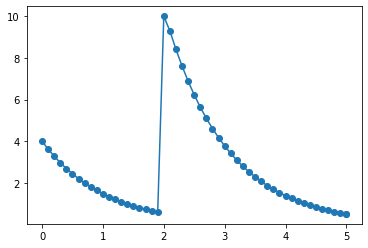

In [76]:
plt.plot(odesol.locations, odesol.states.mean, 'o-')
plt.show()